# 4.2 Elo prediction and the single Elimination Bracket

The long-term rank correlation value of the "Elo on the Single Elimination Bracket" in figure 4.1 is slightly below what is observed in other formats tested. In this notebook, I investigate the case starting with a simple clearly defined model and extending to larger simulation. It provides a first formal identification of what matchmaking overfitting can be. This is fascinating as the Elo and the single elimination bracket are two of the most famous, used and studied algorithms in competition, yet what is next presented is never mentioned nor considered.

## 4.2.1 Formal approach

The problem, when doing simulation with a small number of players, is that the distribution of levels has a massive impact on the ranking behavior. The importance of a population model becomes key. You cannot simply draw values from a distribution - the sample size is too small to be representative.

### Probability Model
I decided to fix a smooth probability table. The model maintains a strict transitive relationship between the players. If P(A wins against B) > 0.5 and P(B wins against C) > 0.5 then P(A wins against C) > 0.5.

In [1]:
def matrixC1():
    table = []
    inc = 0.05
    for i in range(8):
        table.append([round(0.5-i*inc+j*inc,2) for j in range(8)])
    return table

c1 = matrixC1()
c1

[[0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85],
 [0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8],
 [0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75],
 [0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7],
 [0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65],
 [0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6],
 [0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55],
 [0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]]

### Seedings In a Single Elimination Bracket

In [2]:
from utils.sebiter import reprSEB
from utils import treeprob as tp
import math

labels = list(range(8))
seedings = list(reprSEB(labels))
assert len(seedings) == len(set(seedings)) == math.factorial(len(labels)) // 2**(len(labels)-1) == 315

### Metrics

In [3]:
results = []

for seeding in seedings:
    bracket = tp.treeprob(seeding, c1)
    results.append({
        'seeding': seeding,
        'ExpectedScore': [tp.expected_score(seed, bracket) for seed in labels],
        'WinProb': [tp.score_prob(seed, 3, bracket) for seed in labels] # win the final, i.e. win the 3rd round
    })

In [4]:
GROUNDTRUTH = [sum(c1[seed]) for seed in labels]
GROUNDTRUTH

[5.4, 5.0, 4.6, 4.2, 3.8, 3.4, 3.0, 2.6]

In [5]:
from utils.metrics import argmin, argmax
from scipy import stats

NB = len(labels)
fav = [0 for i in range(NB)]
scoring = [0 for i in range(NB)]
mins = [1 for i in range(NB)]
maxs = [0 for i in range(NB)]
worst_es = (None, 1.0)
worst_wp = (None, 1.0)

for result in results:
    for i in labels:
        mins[i] = min(mins[i], result['WinProb'][i])
        maxs[i] = max(maxs[i], result['WinProb'][i])
        if argmax(result['WinProb']) == i:
            fav[i] += 1
        if argmax(result['ExpectedScore']) == i:
            scoring[i] += 1
        result['GTCOR_ES'] = stats.kendalltau(GROUNDTRUTH, result['ExpectedScore'])[0]
        result['GTCOR_WP'] = stats.kendalltau(GROUNDTRUTH, result['WinProb'])[0]
        if result['GTCOR_WP'] < worst_wp[1]:
            worst_wp = (result['seeding'], result['GTCOR_WP'])
        if result['GTCOR_ES'] < worst_es[1]:
            worst_es = (result['seeding'], result['GTCOR_ES'])

In [6]:
print('worst seed regarding winner probabilities', worst_wp[0], worst_wp[1], '\n')
print('worst seed regarding expected score', worst_es[0], worst_es[1], '\n')

for i in labels:
    print(f'player {i} win prob:', f'min = {mins[i]:.4f},',
          f'max = {maxs[i]:.4f},',
          f'favorite in {fav[i]}',
          f', topscorer in {scoring[i]}')

worst seed regarding winner probabilities (0, 1, 2, 4, 3, 7, 5, 6) 0.7857142857142856 

worst seed regarding expected score (0, 3, 1, 4, 2, 5, 6, 7) 0.2857142857142857 

player 0 win prob: min = 0.2560, max = 0.4014, favorite in 299 , topscorer in 205
player 1 win prob: min = 0.1798, max = 0.3096, favorite in 16 , topscorer in 68
player 2 win prob: min = 0.1235, max = 0.2390, favorite in 0 , topscorer in 32
player 3 win prob: min = 0.0851, max = 0.1806, favorite in 0 , topscorer in 9
player 4 win prob: min = 0.0570, max = 0.1344, favorite in 0 , topscorer in 1
player 5 win prob: min = 0.0364, max = 0.0915, favorite in 0 , topscorer in 0
player 6 win prob: min = 0.0218, max = 0.0607, favorite in 0 , topscorer in 0
player 7 win prob: min = 0.0118, max = 0.0354, favorite in 0 , topscorer in 0


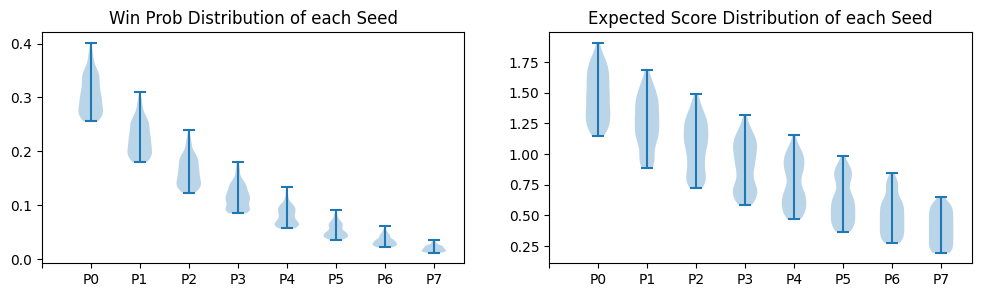

In [7]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(12, 3))


win_dist = [[result['WinProb'][i] for result in results] for i in labels]
exp_dist = [[result['ExpectedScore'][i] for result in results] for i in labels]

axs[0].violinplot(win_dist)
axs[0].set_xticks(list(range(NB+1)), labels=[None]+[f'P{i}' for i in range(NB)])
axs[0].set_title('Win Prob Distribution of each Seed')

axs[1].violinplot(exp_dist)
axs[1].set_xticks(list(range(NB+1)), labels=[None]+[f'P{i}' for i in range(NB)])
axs[1].set_title('Expected Score Distribution of each Seed')

plt.show()

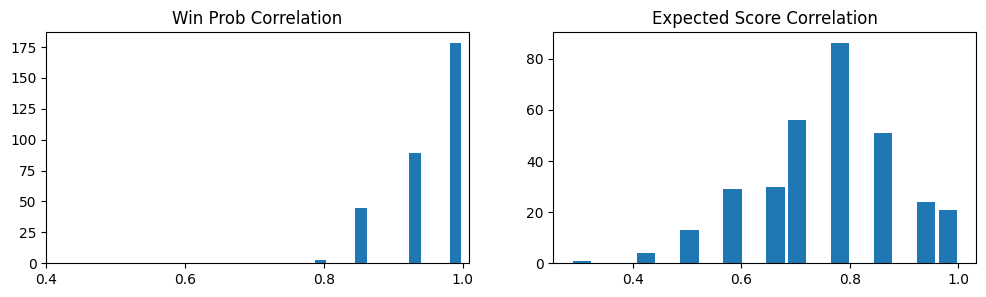

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(12, 3))

axs[0].hist(x=[result['GTCOR_WP'] for result in results], bins='auto', rwidth=0.85)
axs[0].set_xticks([0.4, 0.6, 0.8, 1.0])
axs[0].set_title('Win Prob Correlation')

axs[1].hist(x=[result['GTCOR_ES'] for result in results], bins='auto', rwidth=0.85)   
axs[1].set_xticks([0.4, 0.6, 0.8, 1.0])
axs[1].set_title('Expected Score Correlation')

plt.show()